In [14]:
import numpy as np 
import torch 
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import math

In [3]:
sequence_length = 4 
batch_size =1 
input_dim = 512
d_model = 512 
x = torch.randn((batch_size,sequence_length,input_dim))
print(x)

tensor([[[ 0.2309,  0.3735,  0.1614,  ..., -0.4675, -0.1050, -0.0766],
         [-2.2628, -0.6283, -0.6507,  ..., -0.6733, -0.4983,  1.3225],
         [ 1.2907, -0.0922,  1.5088,  ...,  0.3831, -0.0552, -0.3952],
         [-0.4560, -0.5536,  1.4352,  ...,  0.5841,  0.2999,  0.8142]]])


In [4]:
x.shape

torch.Size([1, 4, 512])

In [5]:
qkv_layer = nn.Linear(input_dim,3*d_model)
qkv_layer

Linear(in_features=512, out_features=1536, bias=True)

In [6]:
qkv = qkv_layer(x)

In [7]:
qkv

tensor([[[ 0.3001,  0.7721, -0.2460,  ...,  0.7420,  0.3374, -0.1398],
         [ 0.1775, -0.9231, -0.8917,  ..., -0.1483, -0.1635, -0.2726],
         [-0.0896, -0.1577, -0.7327,  ...,  0.1006, -0.4323, -0.4967],
         [ 0.0117,  1.1440,  0.9358,  ..., -0.3984, -0.6591,  0.7558]]],
       grad_fn=<ViewBackward0>)

In [8]:
qkv.shape

torch.Size([1, 4, 1536])

Text(0.5, 1.0, 'qkv_distribution')

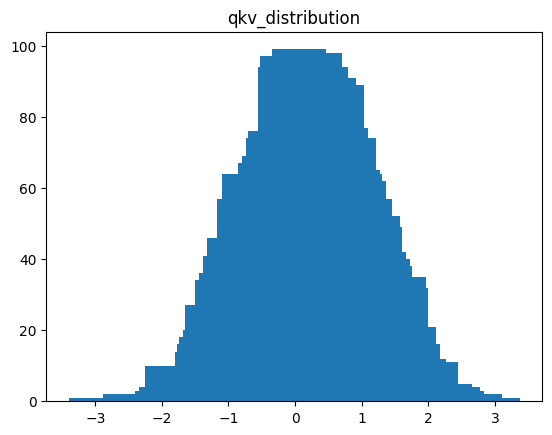

In [9]:
import matplotlib.pyplot as plt 

y_val = torch.histc(qkv,bins=200,min=3,max=3)
x_val = np.arange(-1,1,0.01)*3
plt.bar(x_val,y_val,align='center')
plt.title('qkv_distribution')

In [11]:
num_heads = 8
head_dim = d_model // num_heads

qkv = qkv.reshape(batch_size,sequence_length,num_heads,3* head_dim)
qkv

tensor([[[[ 0.3001,  0.7721, -0.2460,  ..., -0.0321,  0.0878, -0.8277],
          [ 0.4374,  0.3018,  0.1845,  ..., -0.2339, -1.2924,  0.2076],
          [-0.8966, -0.3262, -0.2030,  ..., -0.7290, -0.2542,  0.3987],
          ...,
          [ 1.1106, -0.6505, -0.1613,  ...,  0.6464,  1.0916,  0.5195],
          [ 0.1338,  0.1364, -0.0920,  ..., -0.3930, -0.2792, -0.0622],
          [ 0.2671, -0.0822,  0.3750,  ...,  0.7420,  0.3374, -0.1398]],

         [[ 0.1775, -0.9231, -0.8917,  ..., -0.2862, -0.1096,  0.5222],
          [-1.1022,  0.0986, -0.4443,  ..., -0.3518, -0.5326,  0.0222],
          [-0.7620,  0.7172,  0.3349,  ...,  1.2961,  0.4170,  0.6937],
          ...,
          [ 0.0844,  0.4856, -0.5529,  ..., -0.4811, -0.3288,  0.0064],
          [ 0.3867, -0.3526,  0.0635,  ..., -0.1387,  1.3105,  0.6276],
          [-0.6164,  0.3254,  0.5097,  ..., -0.1483, -0.1635, -0.2726]],

         [[-0.0896, -0.1577, -0.7327,  ..., -0.7157,  0.3648,  0.5498],
          [-0.5974,  0.6431,  

In [12]:
qkv.shape

torch.Size([1, 4, 8, 192])

In [13]:
q,k,v = qkv.chunk(3,dim=-1)
q.shape,k.shape,v.shape

(torch.Size([1, 4, 8, 64]),
 torch.Size([1, 4, 8, 64]),
 torch.Size([1, 4, 8, 64]))

In [15]:
#Self Attention 

d_k = q.size()[-1]
scaled = torch.matmul(q,k.transpose(-2,-1))/math.sqrt(d_k)
scaled.shape

torch.Size([1, 4, 8, 8])

In [16]:
k.T.shape

torch.Size([64, 8, 4, 1])

In [19]:
y = torch.randn(2,3)
torch.transpose(y,0,1)

tensor([[-0.3767,  0.6600],
        [ 1.2470,  0.5032],
        [-0.1676, -0.1463]])

In [20]:
torch.transpose(y,1,1)

tensor([[-0.3767,  1.2470, -0.1676],
        [ 0.6600,  0.5032, -0.1463]])

In [21]:
mask = torch.full(scaled.size(),float('-inf'))
mask = torch.triu(mask,diagonal=1)
mask[0][1]

tensor([[0., -inf, -inf, -inf, -inf, -inf, -inf, -inf],
        [0., 0., -inf, -inf, -inf, -inf, -inf, -inf],
        [0., 0., 0., -inf, -inf, -inf, -inf, -inf],
        [0., 0., 0., 0., -inf, -inf, -inf, -inf],
        [0., 0., 0., 0., 0., -inf, -inf, -inf],
        [0., 0., 0., 0., 0., 0., -inf, -inf],
        [0., 0., 0., 0., 0., 0., 0., -inf],
        [0., 0., 0., 0., 0., 0., 0., 0.]])

In [22]:
(scaled + mask)[0][0]

tensor([[-0.0522,    -inf,    -inf,    -inf,    -inf,    -inf,    -inf,    -inf],
        [-0.0545, -0.2490,    -inf,    -inf,    -inf,    -inf,    -inf,    -inf],
        [ 0.4200, -0.9517,  0.1186,    -inf,    -inf,    -inf,    -inf,    -inf],
        [-0.0781,  0.0821,  0.3732, -0.8871,    -inf,    -inf,    -inf,    -inf],
        [-0.2339,  0.0558,  0.0710,  0.3489,  0.3565,    -inf,    -inf,    -inf],
        [ 0.3285,  0.4705, -0.1266, -0.2184,  0.1617,  0.3114,    -inf,    -inf],
        [-0.9098,  0.5181, -0.0942,  0.6021,  0.3742, -0.4667, -0.2422,    -inf],
        [ 0.2427,  0.2801, -0.5708, -0.6170, -0.6047,  0.2911,  0.3842, -0.0817]],
       grad_fn=<SelectBackward0>)

In [23]:
scaled+= mask 

In [24]:
scaled

tensor([[[[-0.0522,    -inf,    -inf,    -inf,    -inf,    -inf,    -inf,
              -inf],
          [-0.0545, -0.2490,    -inf,    -inf,    -inf,    -inf,    -inf,
              -inf],
          [ 0.4200, -0.9517,  0.1186,    -inf,    -inf,    -inf,    -inf,
              -inf],
          [-0.0781,  0.0821,  0.3732, -0.8871,    -inf,    -inf,    -inf,
              -inf],
          [-0.2339,  0.0558,  0.0710,  0.3489,  0.3565,    -inf,    -inf,
              -inf],
          [ 0.3285,  0.4705, -0.1266, -0.2184,  0.1617,  0.3114,    -inf,
              -inf],
          [-0.9098,  0.5181, -0.0942,  0.6021,  0.3742, -0.4667, -0.2422,
              -inf],
          [ 0.2427,  0.2801, -0.5708, -0.6170, -0.6047,  0.2911,  0.3842,
           -0.0817]],

         [[ 0.6720,    -inf,    -inf,    -inf,    -inf,    -inf,    -inf,
              -inf],
          [-0.5773,  0.2161,    -inf,    -inf,    -inf,    -inf,    -inf,
              -inf],
          [-0.0213, -0.3917,  0.2849,    -inf,  

In [25]:
np.exp(0.5596)/ (np.exp(0.5996) + np.exp(0.404))

0.5272281003462925

In [27]:
attention = F.softmax(scaled,dim=-1)

In [28]:
attention.shape

torch.Size([1, 4, 8, 8])

In [29]:
values = torch.matmul(attention,v)
values.shape

torch.Size([1, 4, 8, 64])

In [30]:
#Function 

def scaled_dot_product(q,k,v,mask=None):
    d_k = q.size()[-1]
    scaled = torch.matmul(q,k.transpose(-1,-2))/math.sqrt(d_k)
    if mask is not None:
        scaled += mask
    attention = F.softmax(scaled,dim=-1)
    values = torch.matmul(attention,v)
    return values,attention

In [31]:
values,attention = scaled_dot_product(q,k,v,mask=None)

In [32]:
attention.shape

torch.Size([1, 4, 8, 8])

In [34]:
attention[0][0]

tensor([[0.1272, 0.1149, 0.1051, 0.1001, 0.2207, 0.0892, 0.1132, 0.1295],
        [0.1111, 0.0915, 0.1319, 0.2578, 0.1235, 0.0887, 0.0920, 0.1034],
        [0.1937, 0.0491, 0.1433, 0.1719, 0.1579, 0.1282, 0.0879, 0.0679],
        [0.1016, 0.1193, 0.1596, 0.0452, 0.1768, 0.1356, 0.0940, 0.1679],
        [0.0902, 0.1205, 0.1223, 0.1615, 0.1627, 0.1086, 0.1371, 0.0971],
        [0.1251, 0.1442, 0.0793, 0.0724, 0.1059, 0.1229, 0.1186, 0.2316],
        [0.0450, 0.1876, 0.1017, 0.2041, 0.1625, 0.0701, 0.0877, 0.1413],
        [0.1598, 0.1659, 0.0708, 0.0676, 0.0685, 0.1677, 0.1841, 0.1155]],
       grad_fn=<SelectBackward0>)

In [35]:
values.size()

torch.Size([1, 4, 8, 64])

In [ ]:
values.size()

torch.Size([1, 4, 8, 64])

In [ ]:
values.size()

torch.Size([1, 4, 8, 64])

In [37]:
values = values.reshape(batch_size,sequence_length,num_heads*head_dim)
values.size()

torch.Size([1, 4, 512])

In [45]:
class MultiheadAttention(nn.Module):
    def __init__(self,input_dim,d_model,num_heads):
        super().__init__()
        self.input_dim=input_dim
        self.d_model=d_model
        self.num_heads = num_heads
        self.head_dim = d_model // num_heads
        self.qkv_model = nn.Linear(input_dim,3*d_model)
        self.linear_layer = nn.Linear(d_model,d_model)
    
    def forward(self,x,mask=None):
        batch_size,sequence_length,input_dim = x.size()
        print(f"x.size():{x.size()}")
        qkv = self.qkv_model(x)
        print(f"qkv.size(): {qkv.size()}")
        qkv = qkv.reshape(batch_size,sequence_length,self.num_heads,3*self.head_dim)
        print(f"qkv.size(): {qkv.size()}")
        qkv = qkv.permute(0,2,1,3)
        print(f"qkv.size(): {qkv.size()}")
        q,k,v = qkv.chunk(3,dim=-1)
        print(f"q.size(): {q.size()}")
        print(f"k.size(): {k.size()}")
        print(f"v.size(): {v.size()}")
        values,attention = scaled_dot_product(q,k,v,mask)
        print(f"values.size(): {values.size()}")
        values = values.transpose(1,2).contiguous().view(batch_size,sequence_length,self.d_model)
        #values = values.reshape(batch_size,sequence_length,self.num_heads,self.head_dim)
        print(f"values.size(): {values.size()}")
        out = self.linear_layer(values)
        print(f"out.size(): {out.size()}")
        return out


In [46]:
#Input 

input_dim = 1024 
d_model = 512 
num_heads = 8

batch_size = 30 
sequence_length = 5
x = torch.randn((batch_size,sequence_length,input_dim))

model = MultiheadAttention(input_dim,d_model,num_heads)

In [47]:
out = model.forward(x)

x.size():torch.Size([30, 5, 1024])
qkv.size(): torch.Size([30, 5, 1536])
qkv.size(): torch.Size([30, 5, 8, 192])
qkv.size(): torch.Size([30, 8, 5, 192])
q.size(): torch.Size([30, 8, 5, 64])
k.size(): torch.Size([30, 8, 5, 64])
v.size(): torch.Size([30, 8, 5, 64])
values.size(): torch.Size([30, 8, 5, 64])
values.size(): torch.Size([30, 5, 512])
out.size(): torch.Size([30, 5, 512])
